# Introduction

This notebook shows sample code for object detection with a json file. These files are particularly difficult to read, because the json files are separately created for each image.

**This object detection data is shown in a json file.** You can see object detection data **in csv file** at [Object Detection in Chest X-Ray with CSV File](https://www.kaggle.com/code/gokifujiya/object-detection-in-chest-x-ray-with-csv-file) and **in xml file** at [Face Mask Object Detection with XML File](https://www.kaggle.com/code/gokifujiya/face-mask-object-detection-with-xml-file), respectively.

# Install and Import Necessary Libraries

First, we install and import necessary libraries.

In [1]:
!pip install pillow

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

import math
import json
from PIL import Image
import os
from glob import glob
import cv2

# PyTorch libraries
import torch
import torchvision
torchvision.__version__
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Upload a JSON File for Object Detection

In [3]:
with open('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/annotations/0015753ccdad6bf8031175da605d0f6f-asset.json', 'r') as f:
    data = json.load(f)

# Print the data.
print(data)

{'asset': {'format': 'jpg', 'id': '0015753ccdad6bf8031175da605d0f6f', 'name': '4679235f3408.jpg', 'path': 'file:F:/ArTaxOr/Araneae/4679235f3408.jpg', 'size': {'width': 3106, 'height': 2071}, 'state': 2, 'type': 1}, 'regions': [{'id': 'oh6LxDplL', 'type': 'RECTANGLE', 'tags': ['Diptera', '_occluded'], 'boundingBox': {'height': 950.9038262668047, 'width': 849.8152997932461, 'left': 997.5161957270849, 'top': 530.6000517063082}, 'points': [{'x': 997.5161957270849, 'y': 530.6000517063082}, {'x': 1847.331495520331, 'y': 530.6000517063082}, {'x': 1847.331495520331, 'y': 1481.5038779731128}, {'x': 997.5161957270849, 'y': 1481.5038779731128}]}, {'id': 'RUY-blCG-', 'type': 'RECTANGLE', 'tags': ['Araneae'], 'boundingBox': {'height': 878.086866597725, 'width': 1093.842866988284, 'left': 1205.1536871123365, 'top': 389.24948293691835}, 'points': [{'x': 1205.1536871123365, 'y': 389.24948293691835}, {'x': 2298.9965541006204, 'y': 389.24948293691835}, {'x': 2298.9965541006204, 'y': 1267.3363495346434},

In [4]:
# Open the JSON file.
with open('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/annotations/0015753ccdad6bf8031175da605d0f6f-asset.json', 'r') as f:
    data = json.load(f)

# Get the filename of the image.
filename = data['asset']['name']

# Loop through each region and extract the bounding box and label information.
annotations = []
for region in data['regions']:
    label = region['tags'][0] # Assume first tag is the label.
    left, top = region['boundingBox']['left'], region['boundingBox']['top']
    width, height = region['boundingBox']['width'], region['boundingBox']['height']
    bbox = [left, top, left + width, top + height] # format: [xmin, ymin, xmax, ymax]
    annotations.append({'bbox': bbox, 'label': label})

print(filename, annotations)

4679235f3408.jpg [{'bbox': [997.5161957270849, 530.6000517063082, 1847.331495520331, 1481.503877973113], 'label': 'Diptera'}, {'bbox': [1205.1536871123365, 389.24948293691835, 2298.9965541006204, 1267.3363495346434], 'label': 'Araneae'}]


# Show a Sample Image

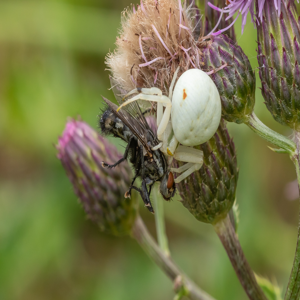

In [5]:
from PIL import Image

# Load image from file.
image = Image.open('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/4679235f3408.jpg')
image = image.resize((300, 300))

# Display image.
image

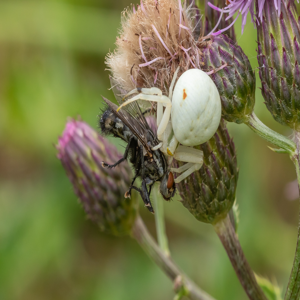

In [6]:
import os

dir_path = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/'
file_name = '4679235f3408.jpg'
full_path = os.path.join(dir_path, file_name)

from PIL import Image

# Load image from file.
image = Image.open(full_path)
image = image.resize((300, 300))

# Display image.
image

# Create Dataset Composed of Image, Bounding Box, and Label

**First, let's create a dataset for one sample data.**

In [7]:
# Create a dataset for one sample data.
def create_dataset(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Define image transforms.
    transform = transforms.Compose([
        transforms.Resize((366, 512)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    
    arthropods = ['BG', 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata', 'Orthoptera']
    

    # Loop through images and extract annotations.
    target = []
    item = data
    i = 0
    
    filename = item['asset']['name']
    image_path = f'/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/{filename}'
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    height, width = item['asset']['size']['height'], item['asset']['size']['width']

    
    for region in item['regions']:
        # Extract bounding box coordinates and label.
        box = [
            region['boundingBox']['left'],
            region['boundingBox']['top'],
            region['boundingBox']['left'] + region['boundingBox']['width'],
            region['boundingBox']['top'] + region['boundingBox']['height']
        ]
        box = [x / max(height, width) for x in box] # Normalize box coordinates.
        label = arthropods.index(region['tags'][0]) # Assuming there is only one label per region.

        # Create dataset entry.
        target.append({
            'boxes': torch.tensor(box, dtype = torch.float32),
            'labels': torch.tensor(label, dtype = torch.int64),
            'image_id': torch.tensor([i]),
            'area': (box[3] - box[1]) * (box[2] - box[0]),
            'iscrowd': torch.zeros(len(box), dtype = torch.int64),
        })

    return image, target

In [8]:
dataset = create_dataset('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/annotations/0015753ccdad6bf8031175da605d0f6f-asset.json')

In [9]:
dataset

(tensor([[[ 0.0569,  0.0569,  0.0569,  ...,  0.2282, -0.1486, -0.1828],
          [ 0.0741,  0.0741,  0.0741,  ...,  0.7762,  0.0056, -0.1999],
          [ 0.0912,  0.0912,  0.1083,  ...,  1.1015,  0.2967, -0.2171],
          ...,
          [-0.4739, -0.4739, -0.4739,  ..., -0.5938, -0.5596, -0.2171],
          [-0.4739, -0.4739, -0.4568,  ..., -0.7308, -0.5424, -0.0458],
          [-0.4739, -0.4568, -0.4568,  ..., -0.7308, -0.3883,  0.0398]],
 
         [[ 0.3277,  0.3277,  0.3102,  ...,  0.3102,  0.0826,  0.0476],
          [ 0.3627,  0.3627,  0.3627,  ...,  0.6954,  0.1527,  0.0301],
          [ 0.3978,  0.3978,  0.4153,  ...,  0.9230,  0.3277,  0.0126],
          ...,
          [-0.0049,  0.0126,  0.0126,  ..., -0.2500, -0.1625,  0.2227],
          [-0.0049, -0.0049,  0.0301,  ..., -0.3725, -0.1625,  0.3627],
          [-0.0049, -0.0049, -0.0049,  ..., -0.4076, -0.0224,  0.4853]],
 
         [[-0.7238, -0.6890, -0.7064,  ...,  0.1302, -0.6367, -0.8110],
          [-0.6715, -0.6715,

In [10]:
image, target = dataset

In [11]:
image

tensor([[[ 0.0569,  0.0569,  0.0569,  ...,  0.2282, -0.1486, -0.1828],
         [ 0.0741,  0.0741,  0.0741,  ...,  0.7762,  0.0056, -0.1999],
         [ 0.0912,  0.0912,  0.1083,  ...,  1.1015,  0.2967, -0.2171],
         ...,
         [-0.4739, -0.4739, -0.4739,  ..., -0.5938, -0.5596, -0.2171],
         [-0.4739, -0.4739, -0.4568,  ..., -0.7308, -0.5424, -0.0458],
         [-0.4739, -0.4568, -0.4568,  ..., -0.7308, -0.3883,  0.0398]],

        [[ 0.3277,  0.3277,  0.3102,  ...,  0.3102,  0.0826,  0.0476],
         [ 0.3627,  0.3627,  0.3627,  ...,  0.6954,  0.1527,  0.0301],
         [ 0.3978,  0.3978,  0.4153,  ...,  0.9230,  0.3277,  0.0126],
         ...,
         [-0.0049,  0.0126,  0.0126,  ..., -0.2500, -0.1625,  0.2227],
         [-0.0049, -0.0049,  0.0301,  ..., -0.3725, -0.1625,  0.3627],
         [-0.0049, -0.0049, -0.0049,  ..., -0.4076, -0.0224,  0.4853]],

        [[-0.7238, -0.6890, -0.7064,  ...,  0.1302, -0.6367, -0.8110],
         [-0.6715, -0.6715, -0.6715,  ...,  0

**Next, we create a dataset for all the data.**

In [12]:
# Create a dataset for all the data.
class ArTaxOrDataset(torch.utils.data.Dataset):
    
    def __init__(self):
        self.root = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/'
        self.ArTaxOr_labels = ['BG', 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata', 'Orthoptera']
        self.transform = transforms.Compose([
            transforms.Resize((366, 512)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        self.data_list = glob(os.path.join(self.root, '*/annotations/*.json'))
        
    def __getitem__(self, idx):
        json_file = self.data_list[idx]
        with open(json_file, 'r') as f:
            data = json.load(f)

        # Loop through images and extract annotations.
        
        item = data # One JSON file one image annotation.

        url = data['asset']['path']
        filename = data['asset']['name']
        name = url.split('/')[-2]
        image_path = os.path.join(self.root, name, filename)
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        height, width = item['asset']['size']['height'], item['asset']['size']['width']


        for region in item['regions']:
            # Extract bounding box coordinates and label.
            box = [
                region['boundingBox']['left'],
                region['boundingBox']['top'],
                region['boundingBox']['left'] + region['boundingBox']['width'],
                region['boundingBox']['top'] + region['boundingBox']['height']
            ]
            box = [x / max(height, width) for x in box] # Normalize box coordinates.
            label = self.ArTaxOr_labels.index(region['tags'][0]) # Assuming there is only one label per region.

            # Create dataset entry.
            target = ({
                'boxes': torch.tensor([box], dtype = torch.float32),
                'labels': torch.tensor([label], dtype = torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.tensor([(box[3] - box[1]) * (box[2] - box[0])]),
                'iscrowd': torch.zeros(len(box), dtype = torch.int64),
            })

        return image, target

    def __len__(self):
        return len(self.data_list)

In [13]:
dataset = ArTaxOrDataset()

In [14]:
root = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/'
glob_list = glob(os.path.join(root, '*/annotations/*.json'))
len(glob_list)

15376

In [15]:
image_list = glob(os.path.join('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/', '*/*.jpg'))
len(image_list)

15376

In [16]:
len(dataset)

15376

In [17]:
x, t = dataset[0]

In [18]:
x

tensor([[[ 0.1426,  0.2282,  0.1768,  ..., -2.0665, -2.0494, -2.0323],
         [ 0.1597,  0.3652,  0.3138,  ..., -1.9809, -1.9638, -1.9638],
         [ 0.1083,  0.1254,  0.0056,  ..., -1.8268, -1.8097, -1.7925],
         ...,
         [-0.4226, -0.5253, -0.5424,  ..., -2.1008, -2.0837, -2.0837],
         [-0.4397, -0.4911, -0.4911,  ..., -2.0837, -2.0837, -2.0837],
         [-0.4911, -0.5424, -0.4911,  ..., -2.0837, -2.0837, -2.0837]],

        [[ 1.7283,  1.7633,  1.6758,  ..., -1.4930, -1.4930, -1.4755],
         [ 1.6408,  1.8333,  1.7633,  ..., -1.3354, -1.3179, -1.3179],
         [ 1.5882,  1.6408,  1.5532,  ..., -1.1954, -1.1604, -1.1253],
         ...,
         [ 0.8354,  0.7304,  0.7304,  ..., -1.9307, -1.9307, -1.9307],
         [ 0.7479,  0.6954,  0.7304,  ..., -1.9307, -1.9307, -1.9307],
         [ 0.7129,  0.6604,  0.7479,  ..., -1.9307, -1.9307, -1.9307]],

        [[ 0.8797,  0.8274,  0.5485,  ..., -1.7870, -1.7870, -1.7696],
         [ 0.7925,  0.9319,  0.6705,  ..., -1

In [19]:
t

{'boxes': tensor([[0.4328, 0.1335, 0.6692, 0.3259]]),
 'labels': tensor([2]),
 'image_id': tensor([0]),
 'area': tensor([0.0455]),
 'iscrowd': tensor([0, 0, 0, 0])}

In [20]:
dataset[1]

(tensor([[[-0.6965, -0.5938, -0.5424,  ..., -1.7925, -1.7754, -1.6384],
          [-0.6623, -0.5938, -0.5253,  ..., -1.8610, -1.8268, -1.7069],
          [-0.6109, -0.5596, -0.5082,  ..., -1.8782, -1.8610, -1.8097],
          ...,
          [-1.8610, -1.9295, -1.9809,  ...,  0.1083, -0.1828, -0.4739],
          [-1.8097, -1.8782, -1.9124,  ...,  0.4166,  0.1426, -0.1486],
          [-1.7925, -1.8610, -1.8782,  ...,  0.5707,  0.3309,  0.1254]],
 
         [[ 0.1702,  0.2402,  0.2752,  ..., -1.4580, -1.4580, -1.3354],
          [ 0.1877,  0.2577,  0.2927,  ..., -1.5805, -1.5105, -1.3704],
          [ 0.2052,  0.2577,  0.3102,  ..., -1.6681, -1.5980, -1.4755],
          ...,
          [-0.8452, -0.9503, -1.0553,  ...,  0.8354,  0.5203,  0.2402],
          [-0.7927, -0.8277, -0.8978,  ...,  1.1506,  0.8354,  0.5378],
          [-0.7577, -0.7927, -0.8102,  ...,  1.2906,  1.0105,  0.7829]],
 
         [[-1.6999, -1.6650, -1.6650,  ..., -1.7870, -1.7696, -1.7870],
          [-1.6824, -1.6650,

# Visualize Sample Data

In [21]:
index2name = ['BG', 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata', 'Orthoptera']
    
# Print the index2name list.
print(index2name)

name2index = {}

# Create a dictionary mapping each name in index2name to its index.
for i in range(len(index2name)):
    name2index[index2name[i]] = i
    
# Print the name2index dictionary.
print(name2index)

['BG', 'Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata', 'Orthoptera']
{'BG': 0, 'Araneae': 1, 'Coleoptera': 2, 'Diptera': 3, 'Hemiptera': 4, 'Hymenoptera': 5, 'Lepidoptera': 6, 'Odonata': 7, 'Orthoptera': 8}


In [22]:
def visualize_dataset(dataset, limit = 3):
    count = 0
    
    # Iterate over each image and its corresponding target in the dataset.
    for image, target in dataset:
        img = image.numpy()
        img = np.transpose(img, (1, 2, 0))
        
        # Extract bounding boxes and labels from the target.
        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        img_height, img_width, _ = img.shape
        
        # Iterate over each box-label pair and visualize it on the image.
        for box, label in zip(boxes, labels):
            x0, y0, x1, y1 = box.tolist()
            x0 *= img_width
            y0 *= img_height
            x1 *= img_width
            y1 *= img_height
            
            # Display the image with the bounding box and label.
            plt.imshow(img)
            plt.gca().add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor = 'r', facecolor = 'none'))
            plt.title(index2name[label], color = 'r')
            plt.show()
            
        count += 1
        
        # Break the loop if the count exceeds the limit.
        if count >= limit:
            break

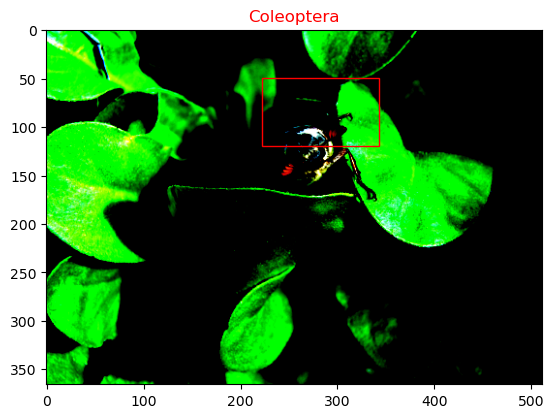

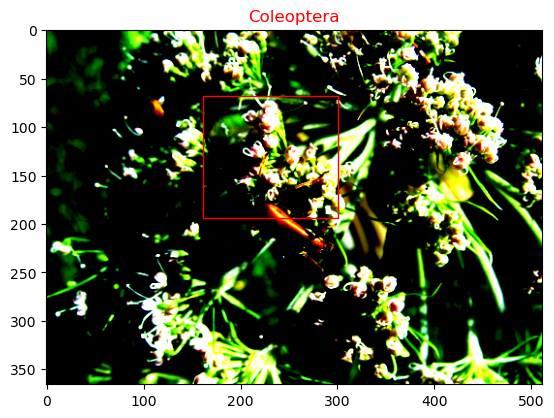

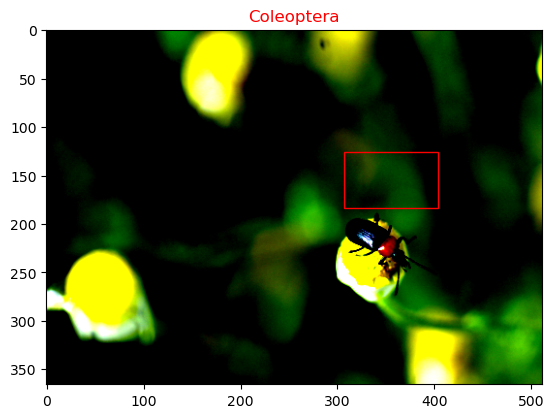

In [23]:
visualize_dataset(dataset)

# Split the Dataset into Training, Validation, and Test Datasets

In [24]:
# Split the dataset into three subsets: train, val, and test.
# The dataset is split based on the provided lengths: 13000 for training, 1376 for validation, and 1000 for testing.
# The generator is initialized with a fixed seed (42) to ensure reproducibility of the split.
train, val, test = torch.utils.data.random_split(dataset = dataset, lengths = [13000, 1376, 1000], generator = torch.Generator().manual_seed(42))

In [25]:
len(train), len(val), len(test)

(13000, 1376, 1000)

In [26]:
# Create data loaders for the train, val, and test subsets.
# The train loader loads data in batches of size 5, does not shuffle the data within each batch, and drops the last batch if it's incomplete.
# The val loader loads data in batches of size 1, which means each sample is treated as a separate batch.
# The test loader loads data in batches of size 24.
train_loader = torch.utils.data.DataLoader(train, batch_size = 5, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 1)
test_loader = torch.utils.data.DataLoader(test, batch_size = 24)

# Import RetinaNet

In [27]:
# Load the RetinaNet model with a ResNet-50 backbone pre-trained on ImageNet.
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained = True)

# Get the number of classes from index2name and the number of anchors from the RetinaNet model.
num_classes = len(index2name)
num_anchors = model.head.classification_head.num_anchors

# Set the number of classes in the RetinaNet model's classification head to the number of classes in the dataset.
model.head.classification_head.num_classes = num_classes

# Modify the classification layer of the RetinaNet model to match the number of classes in the dataset.
# Initialize the weights and biases of the classification layer using specific initialization techniques.
cls_logits = torch.nn.Conv2d(256, num_anchors * num_classes, kernel_size = 3, stride = 1, padding = 1)
torch.nn.init.normal_(cls_logits.weight, std = 0.01)
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
model.head.classification_head.cls_logits = cls_logits

# Freeze all the parameters of the RetinaNet model to prevent them from being updated during training.
for p in model.parameters():
    p.requires_grad = False
    
# Make the parameters of the RetinaNet model's classification head trainable.
for p in model.head.classification_head.parameters():
    p.requires_grad = True
    
# Make the parameters of the RetinaNet model's regression head trainable.
for p in model.head.regression_head.parameters():
    p.requires_grad = True

# Move the model to the GPU (if available) for faster computation.
model.cuda()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Training and Validation with RetinaNet

In [28]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

epoch_number = []
train_losses = []

val_losses = []
model.train()

patience = 0
epochs = 4
batch_size = 5
loss_list = []

# training loop
for epoch in range(epochs):
    
    train_loss = 0
    
    # Iterate over batches in the train_loader.
    for i, (images, targets) in enumerate(train_loader):
        losses = 0
        
        # Iterate over images within the batch.
        for j in range(len(images)):

            image = images[j].unsqueeze(0).cuda()

            boxes = targets["boxes"][j].cuda()
            labels = targets["labels"][j].cuda()
            target = [{"boxes":boxes, "labels":labels}]
            
            # Forward pass through the model and calculate the loss.
            loss_dic = model(image, target)
            loss = sum(loss for loss in loss_dic.values())
            losses += loss
            train_loss += loss.item()
            loss_list.append(loss)
            
        losses /= batch_size
        
        # Zero the gradients, perform backward pass, and update the model parameters.
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 9:
            print("epoch:", epoch + 1,  "iteration:", i + 1,  "loss:", loss.item()) 
    train_losses.append(train_loss / ((i + 1) * batch_size))        
    print("train_loss:", train_loss / ((i + 1) * batch_size))

    # validation loop
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for i, (image, target) in enumerate(val_loader):

            image = image.cuda()

            boxes = target["boxes"][0].cuda()
            labels = target["labels"][0].cuda()
            target = [{"boxes":boxes, "labels":labels}]
            
            # Forward pass through the model and calculate the validation loss.
            loss_dic = model(image, target)
            loss = loss_dic[0]['scores'].sum()
            val_loss += loss.item() / batch_size
            
    val_losses.append(val_loss / len(val))   
    print("val_loss:", val_loss / len(val))
    epoch_number.append(epoch + 1)
    
    # Check for improvement in validation loss and save the model if there is improvement.
    if min(val_losses) < val_loss / len(val):
        patience += 1
        
    else:
        torch.save(model.state_dict(), 'object_detection.pt')
        print('Detected network improvement, saving current model')
                          
    if patience == 2:
        break
    model.train()

epoch: 1 iteration: 10 loss: 4.6217827796936035
epoch: 1 iteration: 20 loss: 1.9171981811523438
epoch: 1 iteration: 30 loss: 4.891775131225586
epoch: 1 iteration: 40 loss: 1.2912323474884033
epoch: 1 iteration: 50 loss: 1.6194173097610474
epoch: 1 iteration: 60 loss: 2.5128517150878906
epoch: 1 iteration: 70 loss: 2.467158317565918
epoch: 1 iteration: 80 loss: 2.5278878211975098
epoch: 1 iteration: 90 loss: 1.1508965492248535
epoch: 1 iteration: 100 loss: 1.606116771697998
epoch: 1 iteration: 110 loss: 1.9655640125274658
epoch: 1 iteration: 120 loss: 2.185311794281006
epoch: 1 iteration: 130 loss: 2.213287115097046
epoch: 1 iteration: 140 loss: 1.706010341644287
epoch: 1 iteration: 150 loss: 1.8237762451171875
epoch: 1 iteration: 160 loss: 1.579277515411377
epoch: 1 iteration: 170 loss: 0.9837599992752075
epoch: 1 iteration: 180 loss: 1.687179446220398
epoch: 1 iteration: 190 loss: 0.7005838751792908
epoch: 1 iteration: 200 loss: 1.1085742712020874
epoch: 1 iteration: 210 loss: 1.31676

# Visualize Results

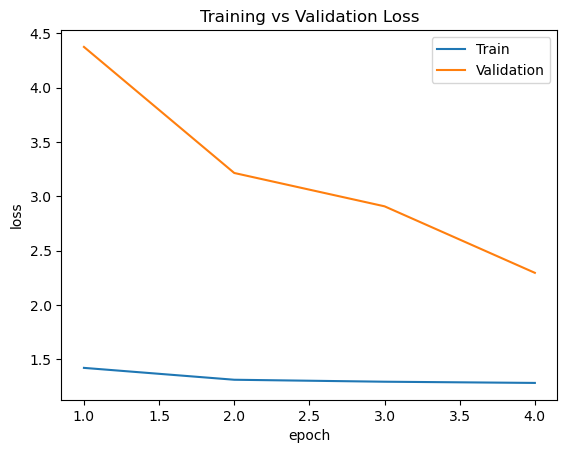

In [29]:
# Plot the training and validation losses over the epochs.
plt.plot(epoch_number, train_losses, label = "Training Loss")
plt.plot(epoch_number, val_losses, label = "Validation Loss")

# Customize the plot by adding a legend, title, and labels to the x and y axes.
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

# Display the plot.
plt.show()

# Inference with Test Dataset

In [30]:
# Import trained network with better loss of validation.
model.load_state_dict(torch.load('object_detection.pt'))

<All keys matched successfully>

In [31]:
# Get a batch of images and targets from the test loader.
dataiter = iter(test_loader)
images, target = next(dataiter)

# Move the images to the GPU if available.
images = images.cuda()


# Set the model to evaluation mode and perform a forward pass on the images to get predictions.
model.eval()
with torch.no_grad():
    predictions = model(images)
    print(predictions)

# Extract the relevant information from the predictions and convert them to CPU for further processing.
image = (images[0] * 255).to(torch.uint8).cpu()
boxes = predictions[0]["boxes"].cpu()
labels = predictions[0]["labels"].cpu().detach().numpy()
labels = np.where(labels >= len(index2name), 0, labels)
names = [index2name[label.item()] for label in labels]

# Print the names of the predicted classes for the first image in the batch.
print(names)

[{'boxes': tensor([[0.7718, 0.1924, 1.2871, 0.6708],
        [0.7718, 0.1924, 1.2871, 0.6708],
        [0.7718, 0.1924, 1.2871, 0.6708],
        [0.2828, 0.7464, 0.7761, 1.2114],
        [0.5479, 0.1617, 1.0428, 0.6130],
        [0.7718, 0.1924, 1.2871, 0.6708],
        [0.3608, 0.7212, 0.8493, 1.1777],
        [0.5479, 0.1617, 1.0428, 0.6130],
        [0.3439, 0.6274, 0.8401, 1.0880],
        [0.7718, 0.1924, 1.2871, 0.6708],
        [0.2828, 0.7464, 0.7761, 1.2114],
        [0.3213, 0.4710, 0.8147, 0.9338],
        [0.5479, 0.1617, 1.0428, 0.6130],
        [0.5479, 0.1617, 1.0428, 0.6130],
        [0.2828, 0.7464, 0.7761, 1.2114],
        [0.2755, 0.5605, 0.7725, 1.0246],
        [0.2828, 0.7464, 0.7761, 1.2114],
        [0.5479, 0.1617, 1.0428, 0.6130],
        [0.2755, 0.5605, 0.7725, 1.0246],
        [0.2755, 0.5605, 0.7725, 1.0246],
        [0.2755, 0.5605, 0.7725, 1.0246],
        [0.3608, 0.7212, 0.8493, 1.1777],
        [0.7718, 0.1924, 1.2871, 0.6708],
        [0.5479, 0.1617

**Next, we will choose a box having a score more than 0.5.**

In [32]:
# Choose a box having a score more than 0.5.
boxes = []
names = []

# Iterate over the predicted boxes and scores.
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    
    # Check if the score is greater than 0.5.
    if score > 0.5:
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        
        # Check if the label index exceeds the length of index2name and replace it with 0 if true.
        if label >= len(index2name):
            label = 0
            
        # Retrieve the corresponding name from index2name using the label index.
        name = index2name[label]
        names.append(name)
        

# Convert the boxes list to a tensor.
boxes = torch.tensor(boxes)

# Print the image, boxes, and names.
print(image)
print(boxes)
print(names)

tensor([[[177,   4,  39,  ..., 219, 241, 197],
         [ 26,  35,  22,  ...,  16,  42, 219],
         [ 39,  22,  17,  ...,  37,  33, 215],
         ...,
         [206, 224, 176,  ..., 211, 154, 167],
         [176, 149, 132,  ..., 197, 184, 176],
         [193, 167, 158,  ..., 250, 180, 158]],

        [[162, 224,   9,  ...,  37,  55,  28],
         [ 13,   9, 247,  ...,  73,  95,  41],
         [ 22, 251, 242,  ...,  90,  90,  37],
         ...,
         [ 10,  24, 190,  ..., 253, 204, 217],
         [235, 195, 141,  ..., 248, 248, 226],
         [244, 213, 172,  ...,  86, 253, 204]],

        [[ 70, 106, 141,  ..., 110, 137, 114],
         [154, 132, 101,  ..., 137, 159, 123],
         [154, 110,  97,  ..., 150, 154, 119],
         ...,
         [ 48,  52, 206,  ...,  43, 250,   8],
         [  8, 202, 157,  ...,  43,  48,  26],
         [ 26, 224, 179,  ..., 137,  57, 255]]], dtype=torch.uint8)
tensor([])
[]


**Moreover, we will choose a box having the maximum score.**

In [33]:
# Choose a boxe having the maximum score.
scores = []
boxes = []
names = []

# Iterate over the predicted boxes and scores.
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    scores.append(score)
    
    # Check if the score is equal to the maximum score so far.
    if score == max(scores):
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        
        # Check if the label index exceeds the length of index2name and replace it with 0 if true.
        if label >= len(index2name):
            label = 0
            
        # Retrieve the corresponding name from index2name using the label index.    
        name = index2name[label]
        names.append(name)
        
# Convert the boxes list to a tensor.        
boxes = torch.tensor(boxes)


# Print the image, boxes, and names.
print(image)
print(boxes)
print(names)

tensor([[[177,   4,  39,  ..., 219, 241, 197],
         [ 26,  35,  22,  ...,  16,  42, 219],
         [ 39,  22,  17,  ...,  37,  33, 215],
         ...,
         [206, 224, 176,  ..., 211, 154, 167],
         [176, 149, 132,  ..., 197, 184, 176],
         [193, 167, 158,  ..., 250, 180, 158]],

        [[162, 224,   9,  ...,  37,  55,  28],
         [ 13,   9, 247,  ...,  73,  95,  41],
         [ 22, 251, 242,  ...,  90,  90,  37],
         ...,
         [ 10,  24, 190,  ..., 253, 204, 217],
         [235, 195, 141,  ..., 248, 248, 226],
         [244, 213, 172,  ...,  86, 253, 204]],

        [[ 70, 106, 141,  ..., 110, 137, 114],
         [154, 132, 101,  ..., 137, 159, 123],
         [154, 110,  97,  ..., 150, 154, 119],
         ...,
         [ 48,  52, 206,  ...,  43, 250,   8],
         [  8, 202, 157,  ...,  43,  48,  26],
         [ 26, 224, 179,  ..., 137,  57, 255]]], dtype=torch.uint8)
tensor([[0.7718, 0.1924, 1.2871, 0.6708]])
['Hymenoptera']


In [34]:
#dataiter = iter(test_loader)
#image, target = next(dataiter)

#image = image.cuda()

#model.eval()
#with torch.no_grad():
    #predictions = model(image)

#print(predictions)

**Furthermore, we will visualize the inference.**

Object Detections (Prediction for Test Data)


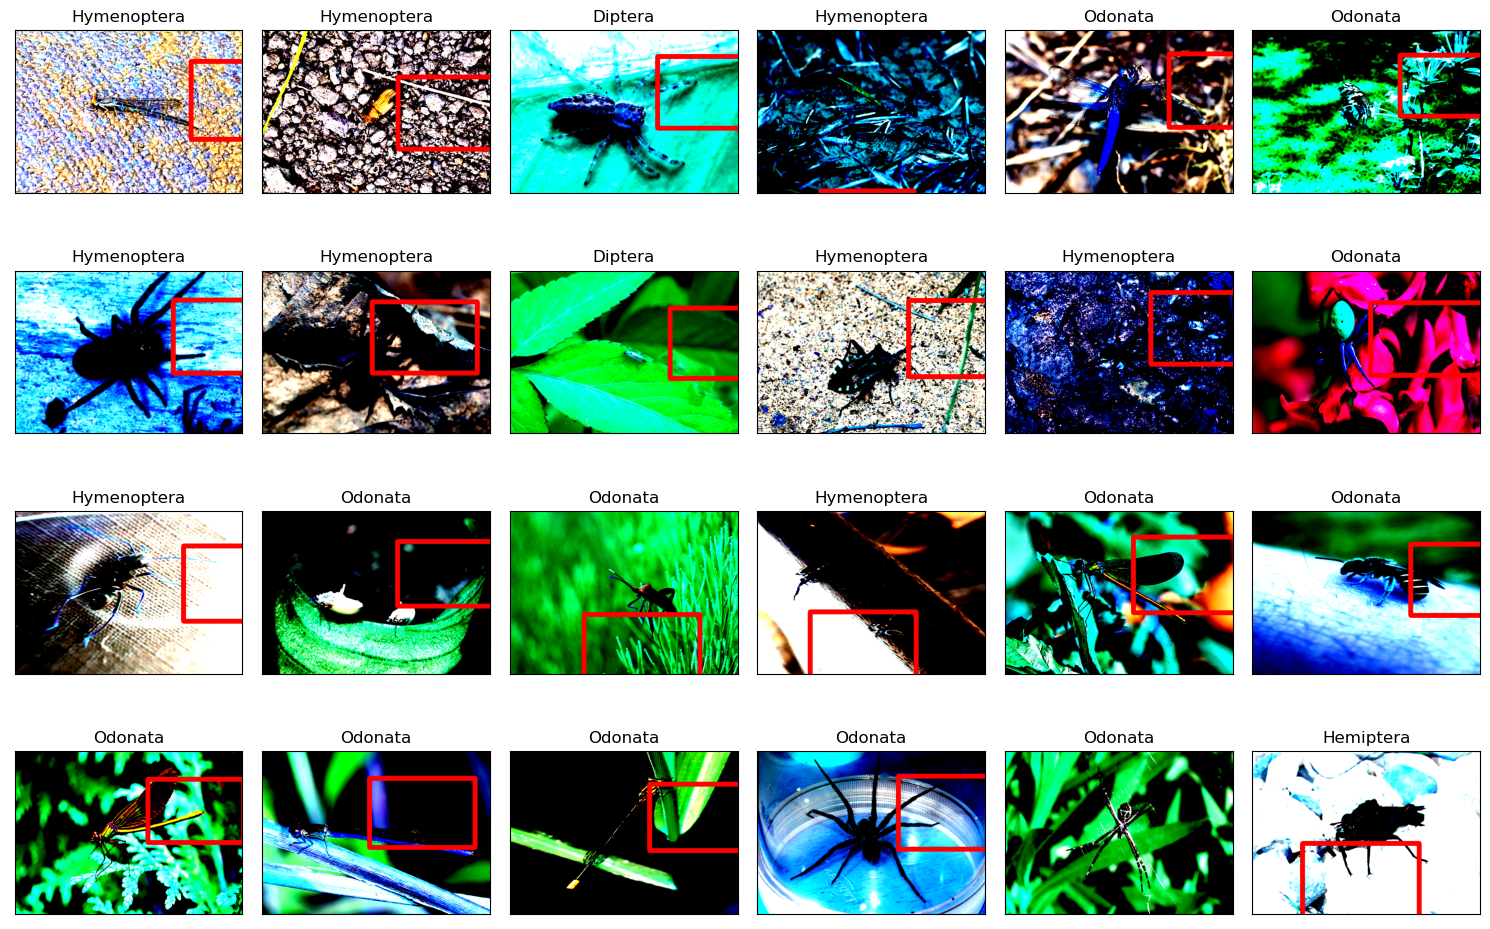

In [35]:
print("Object Detections (Prediction for Test Data)")

# Create a figure and axes for subplots.
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})

# Iterate over the axes in a flat manner.
for i, ax in enumerate(axes.flat):
    
    # Get the i-th image and target from the test dataset.
    img, _ = test[i]

    # Convert the image to a NumPy array.
    img = img.numpy()

    # Transpose the dimensions of the image to match the expected shape.
    img = np.transpose(img, (1, 2, 0))
    
    # Get the height and width of the image.
    img_height, img_width, _ = img.shape  
            
    scores = []
    boxes = []
    names = []
    
    # Iterate over the predicted boxes and scores for the i-th image.
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        # Check if the score is equal to the maximum score among the scores recorded so far.
        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            
            # Check if the label index exceeds the length of index2name and replace it with 0 if true.
            if label >= len(index2name):
                label = 0
                
            # Retrieve the corresponding name from index2name using the label index.
            name = index2name[label]
            names.append(name)
            
    # Convert the boxes list to a tensor.
    boxes = torch.tensor(boxes)
    
    # Draw a rectangle on the image if any names are present.
    if names != []:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.rectangle(img, (int(boxes[0][0].item() * img_width),\
                            int(boxes[0][1].item() * img_height)),\
                      (int(boxes[0][2].item() * img_width),\
                       int(boxes[0][3].item() * img_height)),\
                      (255, 0, 0), 10)

    # Show the image in the current subplot.
    ax.imshow(img)
    
    # Set the title of the subplot based on the detected name or "No Finding" if no names are present.
    if names != []:
        ax.set_title(names[0])
    else:
        ax.set_title("No Finding")

# Adjust the spacing between subplots.
fig.tight_layout()    

# Show the plot.
plt.show()

# Compare the Prediction with the Truth in the Test Data

Object Detections (Truth for Test Data)


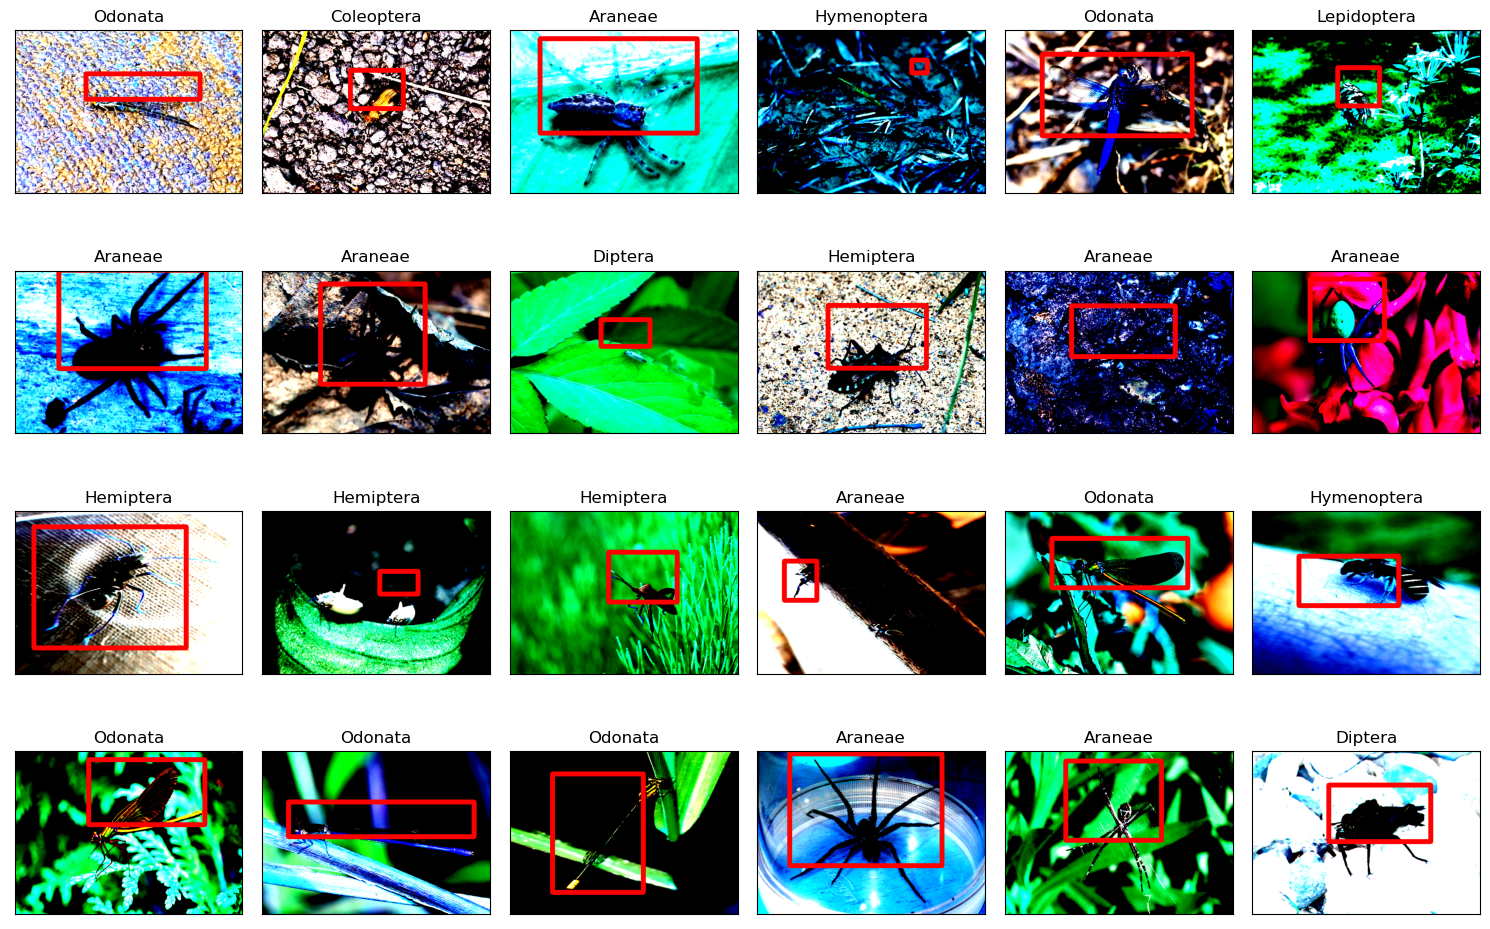

In [36]:
print("Object Detections (Truth for Test Data)")

# Create a figure and axes for subplots.
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})

# Iterate over the axes in a flat manner.
for i, ax in enumerate(axes.flat):
    
    # Get the i-th image and target from the test dataset.
    img, t = test[i]

    # Convert the image to a NumPy array.
    img = img.numpy()

    # Transpose the dimensions of the image to match the expected shape.
    img = np.transpose(img, (1, 2, 0))
    
     # Get the height and width of the image.
    img_height, img_width, _ = img.shape
    
    # Convert the image to the BGR color space for drawing bounding boxes.
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Draw a rectangle on the image using the ground truth box coordinates.
    cv2.rectangle(img, (int(t["boxes"][0][0].item() * img_width),\
                        int(t["boxes"][0][1].item() * img_height)),\
                  (int(t["boxes"][0][2].item() * img_width),\
                   int(t["boxes"][0][3].item() * img_height)),\
                  (255, 0, 0), 10)
    
    # Show the image in the current subplot.
    ax.imshow(img)
    
    # Set the title of the subplot based on the ground truth label.
    ax.set_title(index2name[int(t["labels"][0].item())])
    
# Adjust the spacing between subplots.
fig.tight_layout()    

# Show the plot.
plt.show()

In [37]:
# Create an iterator for the test loader.
dataiter = iter(test_loader)

# Get the next batch of images and targets from the test loader.
image, target = next(dataiter)

# Print the target, which contains the ground truth information.
print(target)

# Print the image, which represents a batch of images.
print(image)

{'boxes': tensor([[[0.3122, 0.2699, 0.8108, 0.4236]],

        [[0.3869, 0.2478, 0.6196, 0.4828]],

        [[0.1323, 0.0535, 0.8215, 0.6324]],

        [[0.6788, 0.1855, 0.7471, 0.2634]],

        [[0.1622, 0.1483, 0.8210, 0.6490]],

        [[0.3768, 0.2299, 0.5600, 0.4648]],

        [[0.1916, 0.0000, 0.8380, 0.6065]],

        [[0.2577, 0.0848, 0.7153, 0.7014]],

        [[0.3991, 0.3046, 0.6146, 0.4677]],

        [[0.3110, 0.2160, 0.7434, 0.6017]],

        [[0.2916, 0.2208, 0.7461, 0.5302]],

        [[0.2543, 0.0573, 0.5817, 0.4331]],

        [[0.0829, 0.0958, 0.7500, 0.8391]],

        [[0.5159, 0.3707, 0.6855, 0.5100]],

        [[0.4324, 0.2534, 0.7338, 0.5576]],

        [[0.1207, 0.3084, 0.2625, 0.5469]],

        [[0.2062, 0.1669, 0.8021, 0.4723]],

        [[0.2059, 0.2768, 0.6437, 0.5814]],

        [[0.3241, 0.0543, 0.8338, 0.4528]],

        [[0.1162, 0.3115, 0.9305, 0.5252]],

        [[0.1862, 0.1394, 0.5858, 0.8668]],

        [[0.1444, 0.0187, 0.8118, 0.7026]],



# Calculate Mean Average Precision (mAP)

In [38]:
boxes = []
scores = []
labels = []

# Iterate over the range of 24.
for i in range(24):
    all_scores = []
    
    # Iterate over the predicted boxes and scores for the i-th image.
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        all_scores.append(score)

        # Check if the score is equal to the maximum score among the scores recorded so far.
        if score == max(all_scores):
            score = torch.tensor(score).item()
            scores.append(score)
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            
            # Check if the label index exceeds the length of index2name and replace it with 0 if true.
            if label >= len(index2name):
                label = 0
            labels.append(label)

            
# Print the lists of boxes, scores, and labels.
print(boxes)
print(scores)
print(labels)

[[0.7717643976211548, 0.19239069521427155, 1.2870728969573975, 0.6707695722579956], [0.5973353385925293, 0.2871955633163452, 1.0761821269989014, 0.7314210534095764], [0.6476854681968689, 0.16317664086818695, 1.1199311017990112, 0.6028661727905273], [0.27963677048683167, 0.9877563714981079, 0.6884569525718689, 1.3871549367904663], [0.720527708530426, 0.1472369134426117, 1.205564260482788, 0.5981279611587524], [0.6501455307006836, 0.1537766307592392, 1.0556814670562744, 0.5287532210350037], [0.6947517991065979, 0.1835169643163681, 1.1743172407150269, 0.6319701075553894], [0.48285964131355286, 0.19578951597213745, 0.9436180591583252, 0.6334168910980225], [0.701725423336029, 0.23291073739528656, 1.1686404943466187, 0.6662251949310303], [0.6653555035591125, 0.1878136545419693, 1.1663625240325928, 0.6548569798469543], [0.6397008895874023, 0.1368413269519806, 1.1170181035995483, 0.5768399834632874], [0.5213088393211365, 0.20017030835151672, 1.0100914239883423, 0.6452891826629639], [0.73978978

In [39]:
# Create a list preds containing a single dictionary. 
preds = [
  dict(
    boxes = torch.tensor(boxes),
    scores = torch.tensor(scores),
    labels = torch.tensor(labels),
  )
]

In [40]:
# Create an iterator for the test loader.
dataiter = iter(test_loader)

# Get the next batch of images and targets from the test loader.
_, target = next(dataiter)

# Print the ground truth box coordinates, removing the dimensions of size 1 using squeeze().
print(target["boxes"].squeeze(1))

# Print the ground truth labels, removing the dimensions of size 1 using squeeze().
print(target["labels"].squeeze(1))

tensor([[0.3122, 0.2699, 0.8108, 0.4236],
        [0.3869, 0.2478, 0.6196, 0.4828],
        [0.1323, 0.0535, 0.8215, 0.6324],
        [0.6788, 0.1855, 0.7471, 0.2634],
        [0.1622, 0.1483, 0.8210, 0.6490],
        [0.3768, 0.2299, 0.5600, 0.4648],
        [0.1916, 0.0000, 0.8380, 0.6065],
        [0.2577, 0.0848, 0.7153, 0.7014],
        [0.3991, 0.3046, 0.6146, 0.4677],
        [0.3110, 0.2160, 0.7434, 0.6017],
        [0.2916, 0.2208, 0.7461, 0.5302],
        [0.2543, 0.0573, 0.5817, 0.4331],
        [0.0829, 0.0958, 0.7500, 0.8391],
        [0.5159, 0.3707, 0.6855, 0.5100],
        [0.4324, 0.2534, 0.7338, 0.5576],
        [0.1207, 0.3084, 0.2625, 0.5469],
        [0.2062, 0.1669, 0.8021, 0.4723],
        [0.2059, 0.2768, 0.6437, 0.5814],
        [0.3241, 0.0543, 0.8338, 0.4528],
        [0.1162, 0.3115, 0.9305, 0.5252],
        [0.1862, 0.1394, 0.5858, 0.8668],
        [0.1444, 0.0187, 0.8118, 0.7026],
        [0.2674, 0.0605, 0.6864, 0.5489],
        [0.3377, 0.2097, 0.7850, 0

In [41]:
# Create a list target containing a single dictionary. 
target = [
  dict(
    boxes = target["boxes"].squeeze(1),
    labels = target["labels"].squeeze(1),
  )
]

In [42]:
# Import the MeanAveragePrecision metric from torchmetrics.detection.mean_ap module.
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Create an instance of the MeanAveragePrecision metric with the specified task (multiclass),
# number of classes (9), and average calculation method (None).
metric = MeanAveragePrecision(task = "multiclass", num_classes = 9, average = None)

# Update the metric with the predicted values (preds) and the ground truth values (target).
metric.update(preds, target)

# Import the pprint module for pretty-printing the metric results.
from pprint import pprint

# Compute and print the metric results using the pprint function.
pprint(metric.compute())

{'map': tensor(0.),
 'map_50': tensor(0.),
 'map_75': tensor(0.),
 'map_large': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.),
 'mar_100': tensor(0.),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(0.)}


# Save the Model

Save the trained model to use it later for this or another notebook.

In [43]:
torch.save(model, 'object_detection_ArTaxOr_pred_model.pth')

In [44]:
saved_model = torch.load('/kaggle/working/object_detection_ArTaxOr_pred_model.pth')

In [45]:
saved_model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Conclusion

**The results did not appear to be sufficient to detect an insect properly. Classification of insects is also considerably difficult.**

Although this task is not related to the medical field, it is also expected that object detection can be used for different medical images to detect various medical findings.

I am a medical doctor working on **artificial intelligence (AI) for medicine**. At present AI is also widely used in the medical field. Particularly, AI performs in the healthcare sector following tasks: **image classification, object detection, semantic segmentation, GANs, text classification, etc**. **If you are interested in AI for medicine, please see my other notebooks.**